In [1]:
using Flux.Tracker

# Gradientes

### Automatic differentiation

In [4]:
f(x) = 3x^2 + 2x + 1;


In [5]:
df(x) = Tracker.gradient(f, x; nest = true)[1];

In [6]:
df(2)

14.0 (tracked)

In [7]:
d2f(x) = Tracker.gradient(df, x; nest = true)[1];

In [8]:
Tracker.gradient(f, 2; nest = true)

(14.0 (tracked),)

Podemos sacar el gradiente con respecto a múltiples parámetros

In [9]:
f(W, b, x) = W * x + b;
Tracker.gradient(f, 2, 3, 4)

(4.0 (tracked), 1.0 (tracked), 2.0 (tracked))

Podemos tener cientos de parámetros!
Podemos tratar a nuestros parámetros como 'params', así los convertimos en números duales

In [5]:
using Flux

In [ ]:
W = param(2) 
b = param(3)
f(x) = W * x + b;

gradient es una zero-argument function. No necesita los argumentos porque params indica qué diferenciar

In [ ]:
grads = Tracker.gradient(() -> f(4), params(W, b));

### Resultado: 
La derivada de f(W, b), el gradiente que obtenemos es un vector con los componentes grads[W] y grads[b]

In [ ]:
grads[W]

In [11]:
grads[b]

1.0 (tracked)

## Modelo simple de regresión lineal

In [8]:
using Flux.Tracker
using Flux

In [11]:
W = rand(2, 5)

2×5 Array{Float64,2}:
 0.874394  0.422542  0.792736  0.504871  0.614578
 0.103252  0.428282  0.873812  0.815934  0.164019

In [12]:
b = rand(2)

2-element Array{Float64,1}:
 0.5798411120937752  
 0.006472065439024677

In [5]:
predict(x) = W*x .+ b


2-element Array{Float64,1}:
 1.8809317243166581
 0.9570435976874905

In [6]:
function loss(x, y)
  ŷ = predict(x)
  sum((y .- ŷ).^2)
end

x, y = rand(5), rand(2) 
loss(x, y) 

2.4517644423909983

 * Queremos minimizar la loss function.
 * Tomamos los gradientes de W y b con respecto la función de loss
 * Aplicamos gradient descent 

In [13]:
W = param(W)
b = param(b)

gs = Tracker.gradient(() -> loss(x, y), params(W, b))

Grads(...)


* Teniendo los gradientes podemos ir actualizando W para entrenar el modelo
* update!(W, Δ) aplica W = W + Δ
* Δ vendría a ser el learnig rate, es decir cuánto avanzar en la dirección que indica el gradiente

In [24]:
using Flux.Tracker: update!
alpha = 0.1
Δ = gs[W]
gb = gs[b]
update!(W, -alpha*Δ)
update!(b,-alpha*gb);

loss(x, y) 

0.03619679816146246 (tracked)

Usando estas herramientas podemos llevar a cabo, en principio, modelos de Deep Learning

# Capas

### Redes Neuronales
* Básicamente están construídas por muchas que pasan su output por una función de activación.
* Vamos a usar la función de activación sigmoid (σ) que es muy común.
* Después el output se pasa a la siguiente capa

### Forma naive de crear una red

In [78]:
function sigmoid(x)
    return 1/(1+exp(-x))
end

W1 = param(rand(7, 10))
b1 = param(rand(7))
layer1(x) = W1 * x .+ b1

W2 = param(rand(5, 7))
b2 = param(rand(5))
layer2(x) = W2 * x .+ b2

model(x) = layer2(sigmoid.(layer1(x)))
model(rand(10))

Tracked 5-element Array{Float64,1}:
 3.4019829423453585
 3.8415179131657275
 4.999097303541656 
 4.128461882116595 
 3.2419384862385954

Podemos usar la función sigmoid de Flux

In [79]:
model(x) = layer2(σ.(layer1(x)))
model(rand(10))

Tracked 5-element Array{Float64,1}:
 3.3620712520075404
 3.792557699872951 
 4.920905790499446 
 4.027821581035932 
 3.199850669309937 

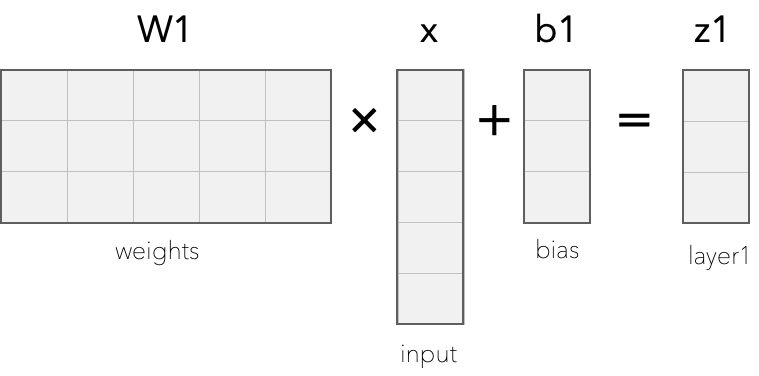
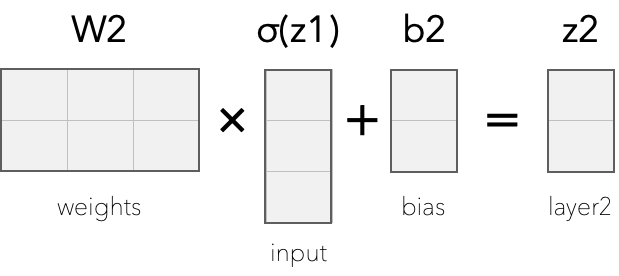

* Creamos una función para crear capas lineales
* Estas capas son las mismas que flux implementa en Dense

In [14]:
function linear(in, out)
  W = param(randn(out, in))
  b = param(randn(out))
  x -> W * x .+ b
end

linear1 = linear(5, 3) 
linear2 = linear(3, 2)

model(x) = linear2(σ.(linear1(x)))

model(rand(5)) 

Tracked 2-element Array{Float64,1}:
  1.077676442887153  
 -0.07162517761343418

* Podemos tener una lista de capas con la función de output final a aplicar
* foldl funciona como un reduce
* va pasando al vector x transformandolo en cada capa de la lista
* en vez de crear la capa nosotros, usamos Dense de Flux

In [15]:

layers = [Dense(10, 5, σ), Dense(5, 2), softmax]

model(x) = foldl((x, m) -> m(x), layers, init = x)

model(rand(10)) 

Tracked 2-element Array{Float32,1}:
 0.392105f0
 0.607895f0

Flux nos facilita el contrsuctor Chain para no tener que hacer ese reduce nosotros mismos

In [16]:
model2 = Chain(
  Dense(10, 5, σ),
  Dense(5, 2),
  softmax)

model2(rand(10))

Tracked 2-element Array{Float32,1}:
 0.46175814f0
 0.53824186f0

#### Red en Keras de Python

In [ ]:
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

También podemos pensar a Chain como una composición de funciones!

In [17]:
m = Dense(5, 2) ∘ Dense(10, 5, σ)

m(rand(10))

Tracked 2-element Array{Float32,1}:
 -0.24105902f0
 -0.5822575f0 

Podemos usar Chain también para encadenar cualquier tipo de funciones de Julia

In [20]:
m = Chain(x -> x^2, x -> x+1)

m(5)

26